<a href="https://colab.research.google.com/github/seyeala/HX_Mooney_Rivlin-CurevFit/blob/main/Hardwarex_MR_curvefit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from scipy.interpolate import interp1d
from google.colab import drive

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from google.colab import drive
from scipy.interpolate import interp1d

# Mount Google Drive
drive.mount('/content/drive')

# Parameters
strain_cutoff = 0.2  # Define your strain cutoff value
foldername = 'otest'
unifilenames = ['uni1.csv', 'uni2.csv','uni3.csv', 'uni4.csv','uni5.csv']  # Add more uniaxial test filenames as needed
planarfilenames = ['shear1.csv', 'shear2.csv']  # Add more planar test filenames as needed

trainableoffset=False
dstraininput=0.00
dstressinput=0.000





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
from scipy import stats



In [6]:
def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    if n == 0:
        return np.nan, np.nan  # Return NaN if data is empty
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of the mean
    if n > 1:  # Ensure there are enough samples for t distribution
        margin = sem * stats.t.ppf((1 + confidence) / 2., n-1)
    else:
        margin = np.nan  # Not enough samples to calculate margin
    return mean, margin

mean_C1, ci_C1 = mean_confidence_interval(filtered_C1)
mean_C2, ci_C2 = mean_confidence_interval(filtered_C2)

print(f"Mean C1: {mean_C1}, Confidence Interval: {ci_C1}")
print(f"Mean C2: {mean_C2}, Confidence Interval: {ci_C2}")


NameError: name 'filtered_C1' is not defined

In [7]:
def aggregate_data(file_paths, strain_cutoff=0.2):
    # Initialize empty lists to store aggregated data
    aggregated_strain = []
    aggregated_stress = []

    for file_path in file_paths:
        data = pd.read_csv(file_path, header=None)
        # Filter data based on strain cutoff before aggregating
        filtered_data = data[data[0] <= strain_cutoff]
        aggregated_strain.extend(filtered_data[0].tolist())
        aggregated_stress.extend(filtered_data[1].tolist())

    return np.array(aggregated_strain), np.array(aggregated_stress)

# Construct full file paths for uniaxial and planar files
unifile_paths = [f'/content/drive/MyDrive/{foldername}/{filename}' for filename in unifilenames]
planarfile_paths = [f'/content/drive/MyDrive/{foldername}/{filename}' for filename in planarfilenames]

# Aggregate uniaxial and planar data
uni_strain, uni_stress = aggregate_data(unifile_paths)
planar_strain, planar_stress = aggregate_data(planarfile_paths)


In [8]:

def train_model(uni_strain, uni_stress, planar_strain, planar_stress, epochs=4000, learning_rate=0.005):

    # Convert to tensors
    strain_uni = tf.convert_to_tensor(uni_strain, dtype=tf.float32)
    stress_real_uni = tf.convert_to_tensor(uni_stress, dtype=tf.float32)
    strain_planar = tf.convert_to_tensor(planar_strain, dtype=tf.float32)
    stress_real_planar = tf.convert_to_tensor(planar_stress, dtype=tf.float32)

    # Calculate the number of data points in each dataset after applying cutoff
    num_uni = len(uni_strain)
    num_planar = len(planar_strain)


    # Calculate weights based on the number of data points
    weight_uni = num_planar / (num_uni + num_planar)
    weight_planar = num_uni / (num_uni + num_planar)

    def stress_uni(C1, C2, strain):
        lambda_ = strain + 1
        return 2 * (C1 * (lambda_ - 1 / lambda_**2) + C2 * (1 - 1 / lambda_**3)) # refrence Methodical fitting for mathematical models of Rubber-like materials Michel Destrade1, Giuseppe Saccomandi; also
        #Hyperelastic behavior of polymers page 135 for True stress

    def stress_planar(C1, C2, strain): # ref Hyperelastic behavior of polymers page 135

        lambda_ = strain + 1
        return 2 * (C1 + C2) *(lambda_ - 1 / lambda_**3)



    # Calculate the percentage error loss
    def percentage_error_loss(y_true, y_pred, epsilon=1e-8):
        return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + epsilon))) * 100.0

    def absloss(y_true, y_pred, epsilon=1e-8):
        return tf.reduce_mean(tf.abs((y_true - y_pred))) * 100.0

    def max_error_loss(y_true, y_pred):
      return tf.reduce_max(tf.abs(y_true - y_pred))

    # Calculate the slope error loss
    def slope_error_loss(y_true, y_pred, epsilon=1e-8):
        dy_true = y_true[1:] - y_true[:-1]
        dy_pred = y_pred[1:] - y_pred[:-1]
        return tf.reduce_mean(tf.abs((dy_true - dy_pred) / (dy_true + epsilon))) * 100.0

    # Define the loss function with weighted losses
    def loss_fn(stress_real_uni, stress_uni_pred, stress_real_planar, stress_planar_pred):
        loss_uni = absloss(stress_real_uni, stress_uni_pred)
        loss_planar = absloss(stress_real_planar, stress_planar_pred)
        total_loss_uni = loss_uni
        total_loss_planar = loss_planar
        return weight_uni * total_loss_uni + weight_planar * total_loss_planar
    # Define the custom model with trainable parameters C1, C2, and constrained reference shifts


    def mooney_loss(stress_real_uni, stress_uni_pred, strain_uni, stress_real_planar, stress_planar_pred, strain_planar):
        lambda_uni = strain_uni + 1
        lambda_planar = strain_planar + 1

        # Calculate the uni stress loss
        uni_stress_loss = tf.reduce_mean(tf.abs(stress_real_uni - stress_uni_pred) / (lambda_uni**2 - 1 / lambda_uni))

        # Calculate the planar stress loss
        #planar_stress_loss = tf.reduce_mean(tf.abs(stress_real_planar - stress_planar_pred) / (lambda_planar**2 - 1 / lambda_planar**2))
        planar_stress_loss = tf.reduce_mean(tf.abs(stress_real_planar - stress_planar_pred) / (lambda_planar**2 - 1 / lambda_planar))
        # Combine the losses
        return uni_stress_loss + planar_stress_loss



    class MooneyRivlinModel(tf.keras.Model):
        def __init__(self, dstrain=0.01,dstress=0.005, trainofset=False):  # Let d be a parameter that you can adjust
            super(MooneyRivlinModel, self).__init__()
            self.C1 = tf.Variable(0.3, trainable=True, dtype=tf.float32)
            self.C2 = tf.Variable(0.01, trainable=True, dtype=tf.float32)
            self.stress_uni_ref = tf.Variable(0, trainable=trainofset, dtype=tf.float32)
            self.strain_uni_ref = tf.Variable(0, trainable=trainofset, dtype=tf.float32)
            self.stress_plan_ref = tf.Variable(0, trainable=trainofset, dtype=tf.float32)
            self.strain_plan_ref = tf.Variable(0, trainable=trainofset, dtype=tf.float32)
            self.dstrain = dstrain  # Maximum absolute value for reference variables
            self.dstress = dstress  # Maximum absolute value for reference variables

        def call(self, strain_uni, strain_planar):
            # Clip the reference variables before using them in the model prediction
            clipped_stress_uni_ref = tf.clip_by_value(self.stress_uni_ref, -self.dstress, self.dstress)
            clipped_strain_uni_ref = tf.clip_by_value(self.strain_uni_ref, -self.dstrain, self.dstrain)
            clipped_stress_plan_ref = tf.clip_by_value(self.stress_plan_ref, -self.dstress, self.dstress)
            clipped_strain_plan_ref = tf.clip_by_value(self.strain_plan_ref, -self.dstrain, self.dstrain)

            stress_uni_pred = stress_uni(self.C1, self.C2, strain_uni + clipped_strain_uni_ref) + clipped_stress_uni_ref
            stress_planar_pred = stress_planar(self.C1, self.C2, strain_planar + clipped_strain_plan_ref) + clipped_stress_plan_ref
            return stress_uni_pred, stress_planar_pred

    # Instantiate and train the model
    if trainableoffset==True:
        model = MooneyRivlinModel(dstrain=dstraininput,dstress=dstressinput,trainofset=True)
    else:
        model = MooneyRivlinModel()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

    @tf.function
    # Define the training step with error calculation and model updating
    def train_step(strain_uni, stress_real_uni, strain_planar, stress_real_planar, model, optimizer):
        with tf.GradientTape() as tape:
            stress_uni_pred, stress_planar_pred = model(strain_uni, strain_planar)
            #loss = loss_fn(stress_real_uni, stress_uni_pred, stress_real_planar, stress_planar_pred)

            # Using mooney_loss instead of the previous loss function
            loss = mooney_loss(stress_real_uni, stress_uni_pred, strain_uni, stress_real_planar, stress_planar_pred, strain_planar)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Clip the reference variables after updating
        model.stress_uni_ref.assign(tf.clip_by_value(model.stress_uni_ref, -model.dstress, model.dstress))
        model.strain_uni_ref.assign(tf.clip_by_value(model.strain_uni_ref, -model.dstrain, model.dstrain))
        model.stress_plan_ref.assign(tf.clip_by_value(model.stress_plan_ref, -model.dstress, model.dstress))
        model.strain_plan_ref.assign(tf.clip_by_value(model.strain_plan_ref, -model.dstrain, model.dstrain))
        return loss
    # Initialize variables to keep track of the best loss and corresponding C1 and C2 values
    best_loss = float('inf')
    best_C1 = model.C1.numpy()
    best_C2 = model.C2.numpy()

    # Training loop
    epochs = 4000
    for epoch in range(epochs):
        loss = train_step(strain_uni, stress_real_uni, strain_planar, stress_real_planar, model, optimizer)
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.numpy()}')

        # Update the best loss and corresponding C1 and C2 values
        if loss < best_loss:
            best_loss = loss
            best_C1 = model.C1.numpy()
            best_C2 = model.C2.numpy()

    # Output the optimized C1 and C2 values
    print("Optimized C1:", best_C1)
    print("Optimized C2:", best_C2)

    # Generate predictions using the best model
    model.C1.assign(best_C1)
    model.C2.assign(best_C2)
    stress_uni_pred, stress_planar_pred = model(strain_uni, strain_planar)

    # Convert tensors to numpy arrays for plotting
    stress_uni_pred = stress_uni_pred.numpy()
    stress_planar_pred = stress_planar_pred.numpy()

    return model.C1.numpy(), model.C2.numpy(), model

In [9]:
def process_combined_data(uni_strain, uni_stress, planar_strain, planar_stress):
    # Convert data to tensors and apply strain cutoff
    strain_cutoff = 0.2
    uniform_strain_grid = np.linspace(0, strain_cutoff, 50)


    # Example - Assuming a function 'train_model' that encapsulates the training logic
    best_C1, best_C2, model = train_model(uni_strain, uni_stress, planar_strain, planar_stress)

    return best_C1, best_C2, model


Epoch 0, Loss: 1398.890380859375
Epoch 1000, Loss: 1398.7991943359375
Epoch 2000, Loss: 1398.79931640625
Epoch 3000, Loss: 1398.799072265625
Optimized C1: 0.25162637
Optimized C2: 0.018165536


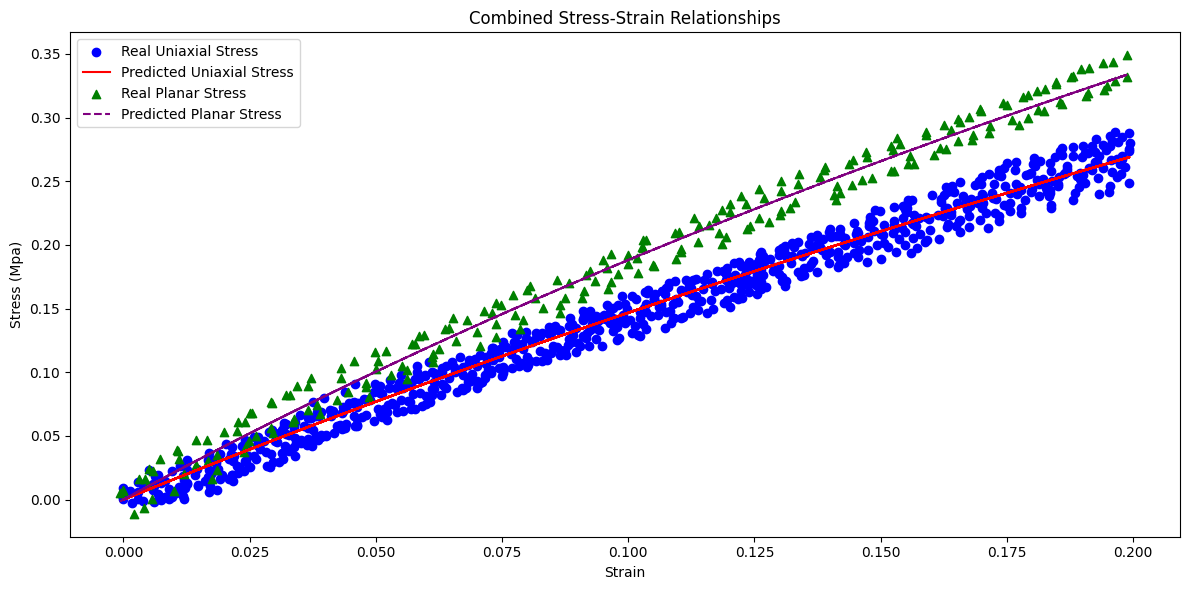

In [11]:

def plot_combined_results(uni_strain, uni_stress, planar_strain, planar_stress, model, C1, C2):
    plt.figure(figsize=(12, 6))

    # Assign model parameters for prediction
    model.C1.assign(C1)
    model.C2.assign(C2)

    # Generate predictions for both uniaxial and planar datasets
    stress_uni_pred, stress_planar_pred = model(uni_strain, planar_strain)

    # Convert tensors to numpy arrays for plotting if needed
    uni_pred_stress = stress_uni_pred.numpy()  # Assuming this returns a numpy-compatible format
    planar_pred_stress = stress_planar_pred.numpy()

    # Plot both real and predicted stresses in one plot
    plt.scatter(uni_strain, uni_stress, color='blue', label='Real Uniaxial Stress', marker='o')
    plt.plot(uni_strain, uni_pred_stress, 'red', label='Predicted Uniaxial Stress', linestyle='-')
    plt.scatter(planar_strain, planar_stress, color='green', label='Real Planar Stress', marker='^')
    plt.plot(planar_strain, planar_pred_stress, 'purple', label='Predicted Planar Stress', linestyle='--')

    plt.xlabel('Strain')
    plt.ylabel('Stress (Mpa)')
    plt.title('Combined Stress-Strain Relationships')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the functions to process and plot the results
best_C1, best_C2, model = process_combined_data(uni_strain, uni_stress, planar_strain, planar_stress)
plot_combined_results(uni_strain, uni_stress, planar_strain, planar_stress,model, best_C1, best_C2)
